<img src="img/vs265header.svg"/>

<h1 align="center">Lab 2 - Supervised Learning <font color="red">  </font> </h1>

In [ ]:
#
#

<h2 align="center">1. Linear Neuron with sigmoidal output nonlinearity </h2> 

Derive the learning rule for the following objective function:

$$ E = \frac{1}{2} \sum_k [T^{(k)} - \sigma(u^{(k)})]^2, $$

where $T$ is the teacher signal and $k$ indexes the sample from our data, using a linear neuron with sigmoidal output nonlinearity:

$$y= \sigma(u) = \frac{1}{1 + e^{-u}}$$
with $u = w^T x = \sum_i w_i x_i$

$$
\begin{align}
    \Delta w &= - \eta \frac{\partial E}{\partial w} \\
    &= \eta \sum_k [T^{(k)} - \sigma(u^{(k)})] \frac{\partial \sigma(u^{(k)})}{\partial w} \\
    &= \eta \sum_k [T^{(k)} - \sigma(u^{(k)})] \sigma(u^{(k)}) [1 - \sigma(u^{(k)})] \frac{\partial u^{(k)}}{\partial w} \\
    &= \eta \sum_k [T^{(k)} - \sigma(u^{(k)})] \sigma(u^{(k)}) [1 - \sigma(u^{(k)})] x^{(k)} \\
    \text{Let } \delta_{y} &= \sum_k [T^{(k)} - \sigma(u^{(k)})] \sigma(u^{(k)}) [1 - \sigma(u^{(k)})] \\
    \Delta w &= \eta \delta_{y} x \\
\end{align}
$$

<h2 align="center">2. Single layer network </h2> 

Train a single neuron to discriminate between the apples and oranges data in apples.npy and oranges.npy. Try this for both a linear neuron and one with a sigmoidal output nonlinearity. (Use $+1/-1$ as the category assignments in the linear case, and $1/0$ in the non-linear case.) Use the code below to visualize the convergence of the solution during learning. You must fill in the code for simulating network itself and learning of the weights. Comment on the differences you observe between the sigmoid and linear case.

In [123]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from utils.lab2_utils import HyperPlanePlotter
import pdb

In [124]:
# Load data
apples  = np.load('data/apples.npy')
oranges = np.load('data/oranges.npy')

# initialize data array
data = np.hstack((apples,oranges))
dimensions, numSamples = data.shape

In [135]:
# initialize teachers, 1/-1 for linear case, 1/0 for non-linear case
halfNumSamples = int(numSamples/2)
teacherLinear = np.ones(numSamples)     
teacherLinear[halfNumSamples:] *= -1
teacherSigmoid = np.ones(numSamples)
teacherSigmoid[halfNumSamples:] *= 0

# number of trials - ## MODIFY THESE SO your learning converges
numTrials = 1000

# learning rates - ## MODIFY THESE SO your learning converges by the end
etaLinear  = 1e-2
etaSigmoid = 2e-1

# intialize plotter
plotter = HyperPlanePlotter(data, apples, oranges, numTrials)
plotEvery = numTrials // 10

In [136]:
def sigmoid(u):
    return 1. / (1. + np.exp(-u))

def sigmoidDeriv(u):
    return sigmoid(u) * (1. - sigmoid(u))

def identity(u): # For the linear case
    return u

def identityDeriv(u): # For the linear case
    return 1

def get_parameters(name):
    if name == "Linear":
        return identity, identityDeriv, teacherLinear, etaLinear
    return sigmoid, sigmoidDeriv, teacherSigmoid, etaSigmoid

In [137]:
def optimizeSingle(name):
    func, funcDeriv, teacher, eta = get_parameters(name)
    
    # initialize weights and bias
    weights = np.random.randn(2, 1)
    bias    = np.random.randn(1)
    
    # initialize plots
    plotter.setupPlotProb2(name, weights, bias)

    print ("\n%s errors: " % name)
    # loop over trials
    for t in range(numTrials):
        errorT = 0
        # initialize weight and bias derivatives
        weightsDeriv = np.zeros_like(weights)
        biasDeriv = np.zeros_like(bias)
        
        # loop over training set
        for i in range(numSamples):
            # compute neuron output
            output = func(weights.T @ data[:,i:i+1] + bias)
            # NOTE - When referencing your data use data[:,i:i+1], NOT data[:, i]!
            #        This is important so you get a shape that is (2,1) not (2,),
            #        which is the same shape as your weights.
            # compute error 
            error = 1/2 * np.sum(np.square(teacher[i] - output))
            # accumulate weight derivative using func & funcDeriv
            delta = (teacher[i] - output) * funcDeriv(weights.T @ data[:,i:i+1] + bias)
            weightsDeriv += delta * data[:,i:i+1]
            # accumulate bias derivative func & funcDeriv
            biasDeriv += delta.reshape(bias.shape)
            # accumulate the error according the objective function into errorT
            errorT += error

        # update weights and bias
        weights += eta * weightsDeriv
        bias += eta * biasDeriv

        # update display of separating hyperplane at plotEvery intervals
        if t % plotEvery == 0:
            plotter.updatePlotProb2(weights, bias)
            print (" %.2f ||" % errorT, end='')
        plotter.plotErrorProb2(name, t, errorT)

<IPython.core.display.Javascript object>


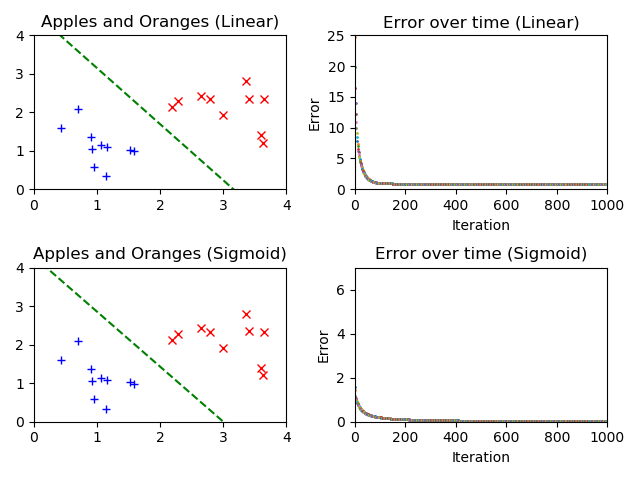


Linear errors: 
 31.86 || 1.01 || 0.92 || 0.92 || 0.92 || 0.92 || 0.92 || 0.92 || 0.92 || 0.92 ||
Sigmoid errors: 
 1.58 || 0.20 || 0.11 || 0.07 || 0.06 || 0.05 || 0.04 || 0.03 || 0.03 || 0.03 ||

In [138]:
plotter.initPlotProb2()
optimizeSingle("Linear")
optimizeSingle("Sigmoid")

Linear works well since this problem is linearly separable, however the sigmoid approach provides a lower error at convergence. With equal learning rates, the sigmoid approach would take longer to converge.

<h2 align="center">3. Multilayer network </h2> 

Augment the data from question 2 with the additional datasets apples2.npy and oranges2.npy. As you can see from plotting out the combined data, the problem of discriminating the apples from the oranges is no longer linearly separable, so we must use a multilayer network for this problem. Start by deriving the learning rules for a two layer network. Then, train a two-layer network (using backprop) to learn to discriminate between apples and oranges. Use the code below to get started. Experiment with adding a momentum term to see if it helps with convergence.

To make sure your solution works, we have provided you with a good initialization of the weights (goodInit=True). After you get this solution working you should experiment with random initializations (goodInit=False). In the description of your solution you should comment on the following:

a) From your learned solution, describe in words how the two layers work together to discriminate between apples and oranges. <br/>
b) The effect momentum has on the learning <br/>
c) The solutions learned when goodInit=False and why they happen <br/>

The network is composed of two layers with the following equations:
$$
\begin{align}
    y_k &= \sigma(\sum_l w_{kl} x_l + b_k) &\\
    z_i &= \sigma(\sum_k v_{ik} y_k + c_i) \\
\end{align}
$$
where $x$ represents the input, $y$ represents the hidden units, and $z$ represents the output.

The error function has the same form as before:
$$
    E = \frac{1}{2} \sum_i [T_i - z_i]^2 \\
$$
We can then use backpropagation to find $\Delta v$ for the output layer based on the error.
$$
\begin{align}
    \Delta v_{ik} &= - \eta \frac{\partial E}{\partial v_{ik}} \\
    &= \eta \sum_i [T_i - z_i] \frac{\partial \sigma(u_{z_i})}{\partial v_{ik}} \\
    &= \eta \sum_i [T_i - z_i] \sigma(u_{z_i}) [1 - \sigma(u_{z_i})] \frac{\partial u_{z_i}}{\partial v_{ik}} \\
    &= \eta \sum_i [T_i - z_i] \sigma(u_{z_i}) [1 - \sigma(u_{z_i})] y_k \\
    &\text{where $u_{z_i} = \sum_k v_{ik} y_k$} \\
\end{align}
$$
This can then be written more compactly using $\delta_{z_i}$.
$$
\begin{align}
    \delta_{z_i} &= \sum_i [T_i - z_i] \sigma(u_{z_i}) [1 - \sigma(u_{z_i})] \\
    \Delta v_{ik} &= \eta \delta_{z_i} y_k \\
\end{align}
$$
We can then propagate the errors with respect to the first layer weights.
$$
\begin{align}
    \Delta w_{kl} &= - \eta \frac{\partial E}{\partial w_{kl}} \\
    &= \eta \sum_i [T_i - z_i] \frac{\partial \sigma(u_{z_i})}{\partial w_{kl}} \\
    &= \eta \sum_i [T_i - z_i] \sigma(u_{z_i}) [1 - \sigma(u_{z_i})] v_{ik} \frac{\partial \sigma(u_{y_k})}{\partial w_{kl}} \\
    &= \eta \sum_i [T_i - z_i] \sigma(u_{z_i}) [1 - \sigma(u_{z_i})] v_{ik} \sigma(u_{y_k}) [1 - \sigma(u_{y_k})] x_l \\
\end{align}
$$
Similarly, this can be written as $\delta_{y_k}$:
$$
\begin{align}
    \delta_{y_k} &= \sigma(u_{y_k}) [1 - \sigma(u_{y_k})] \sum_i \delta_{z_i} v_{ik} \\
    \Delta w_{kl} &= \eta \delta_{y_k} x_l \\
\end{align}
$$

In [139]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from utils.lab2_utils import HyperPlanePlotter
import pdb

In [140]:
# Additionally load 'data/apples2.mat' and 'data/oranges2.mat'
apples  = np.load('data/apples.npy')
oranges = np.load('data/oranges.npy')
apples2 = np.load('data/apples2.npy')                                                                                                                                      
oranges2 = np.load('data/oranges2.npy')

# initialize data array
apples = np.hstack((apples, apples2))
oranges = np.hstack((oranges, oranges2))
data = np.hstack((apples, oranges))
dimensions,numSamples = data.shape
halfNumSamples = int(numSamples/2)

In [141]:
# initialize teacher
teacher = np.ones(numSamples)
teacher[halfNumSamples:] *= 0

# learning rate
eta = 1e-1

# number of trials - you may want to make this smaller or larger
numTrials = 3000

# plotting
plotter = HyperPlanePlotter(data, apples, oranges, numTrials, halfNumSamples)
plotEvery = numTrials // 50
plotErrorEvery = numTrials // 100

In [142]:
def sigmoid(u):
    return 1. / (1. + np.exp(-u))

def sigmoidDeriv(u):
    return sigmoid(u) * (1. - sigmoid(u))

In [143]:
def optimizeMulti(goodInit=True, momentum=False, alpha=0.1):
    # initialize weights and biases
    weightsOne = np.load('init/weightsOne.npy') if goodInit else np.random.randn(2,2) # first layer weights                                                                                                                                        
    biasOne    = np.load('init/biasOne.npy') if goodInit else np.random.randn(2,1)                                                                                                                                                                 
    weightsTwo = np.load('init/weightsTwo.npy') if goodInit else np.random.randn(2,1) # second layer weights                                                                                                                                       
    biasTwo    = np.load('init/biasTwo.npy') if goodInit else np.random.randn(1)                                                                                                                                                                   
     
    # setup plots
    plotter.setupPlotProb3(weightsOne, biasOne, weightsTwo, biasTwo)

    # initialize variables for momentum
    momentumOne = np.zeros_like(weightsOne)
    momentumTwo = np.zeros_like(weightsTwo)
    
    # loop over trials
    for t in range(numTrials):
        errorT = 0 
        # initialize derivative of weights, biases
        weightsOneDeriv = np.zeros_like(weightsOne)
        biasOneDeriv = np.zeros_like(biasOne)
        weightsTwoDeriv = np.zeros_like(weightsTwo)
        biasTwoDeriv = np.zeros_like(biasTwo)

        # loop over training set
        for i in range(numSamples):
            # forward pass - compute y layer
            y = sigmoid(weightsOne.T @ data[:,i:i+1] + biasOne)
            # forward pass - compute z layer
            z = sigmoid(weightsTwo.T @ y + biasTwo)
            # NOTE - When referencing your data use data[:,i:i+1], NOT data[:, i]!
            #        This is important so you get a shape that is (2,1) not (2,),
            #        which is the same shape as your weights.
            # compute error
            error = 1/2 * np.sum(np.square(teacher[i] - z))
            # accumulate second layer derivatives
            deltaTwo = (teacher[i] - z) * sigmoidDeriv(weightsTwo.T @ y + biasTwo)
            weightsTwoDeriv += deltaTwo * y
            biasTwoDeriv += deltaTwo.reshape(biasTwo.shape)
            # accumulate first layer derivatives
            deltaOne = sigmoidDeriv(weightsOne.T @ data[:,i:i+1] + biasOne) * (deltaTwo.T @ weightsTwo.T).T
            weightsOneDeriv += data[:,i:i+1] @ deltaOne.T
            biasOneDeriv += deltaOne.reshape(biasOne.shape)
            # accumulate the error according the objective function into errorT
            errorT += error
                
        # update weights and bias
        weightsOne += eta * weightsOneDeriv + alpha * momentumOne
        biasOne += eta * biasOneDeriv
        weightsTwo += eta * weightsTwoDeriv + alpha * momentumTwo
        biasTwo += eta * biasTwoDeriv
        
        # track previous weight derivatives to use momentum
        if momentum:
            momentumOne = weightsOneDeriv
            momentumTwo = weightsTwoDeriv

        # update display of separating hyperplane at plotEvery intervals
        if t % plotEvery == 0:
            plotter.updatePlotProb3(weightsOne, biasOne, weightsTwo, biasTwo)
        if t % plotErrorEvery == 0:
            plotter.plotErrorProb3(t, errorT)

<IPython.core.display.Javascript object>


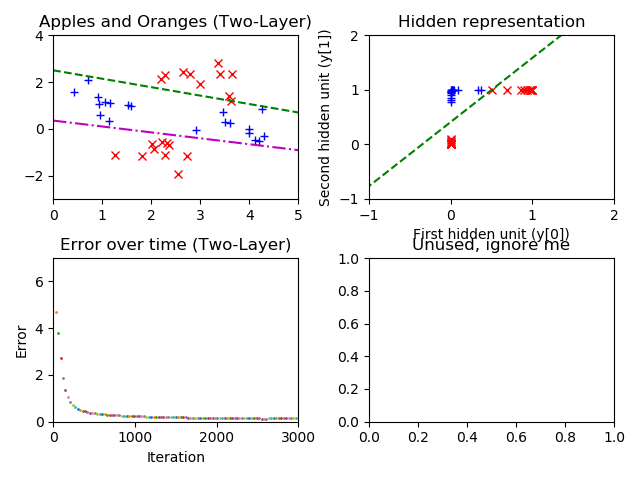

In [145]:
# If your code is correct this will always work. 
# **NOTE** - If your code is incorrect this may still work, 
# you need to verify optimizeMulti() still works sometimes 
# with goodInit=False (see below).
optimizeMulti(goodInit=True, momentum=False)

<IPython.core.display.Javascript object>


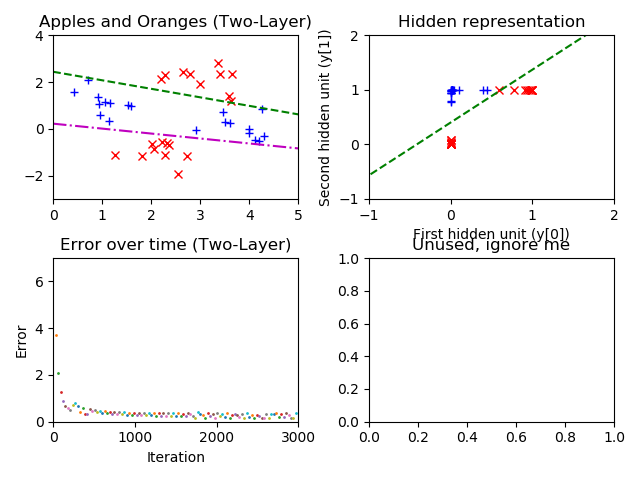

In [153]:
# If your code is correct this will always work. 
optimizeMulti(goodInit=True, momentum=True)

<IPython.core.display.Javascript object>


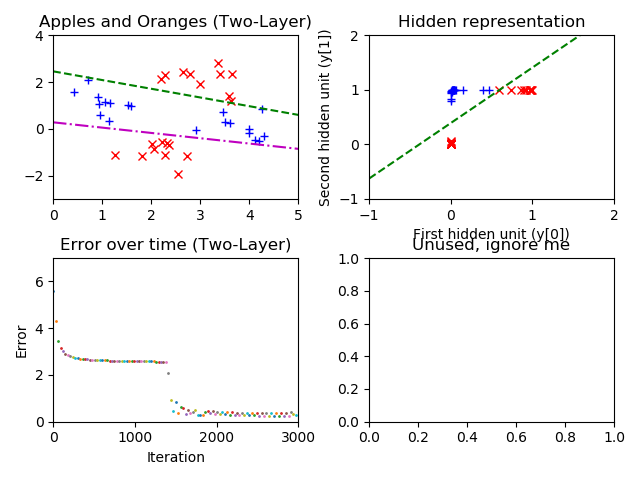

In [150]:
# **VERIFY THIS** - If your code is written correctly this should succeed (Error < 1) at least 1 out of 10 times.
optimizeMulti(goodInit=False, momentum=True) # Run this many times

**YOUR TEXT HERE - Comment on the learned solution, the effect of momentum, and learned solution under random initializations** <br/>
Layer one remaps the data points so that they are linearly separable, and layer two is then able to separate them. The momentum has the effect of incorporating history into the weight update, and its effect is highly dependent on its hyperparameter, alpha. Under random initialization, without momentum more trials get stuck in a local minimum. With momentum, we are able to overcome bad initialization.

<h2 align="center">4. Pattern Discrimination Task <font color="red">[OPTIONAL]</font> </h2> 

Consider the following pattern discrimination task:

![title](img/lab2.4.png)

In this problem you will train a two-layer network to discriminate between these two patterns. First, make a hypothesis about what representation the first layer will learn in order to allow the second layer to discriminate between these two patterns. Then, train a two-layer neural network to discriminate between these patterns. How many hidden units are needed? What representation is learned by the hidden units in order to solve this problem? Comment on the differences between how you thought to discriminate between the patterns and how the network learned to.

*** YOUR TEXT HERE -- Make a hypothesis about what representation the first layer will learn***
The first layer will learn to represent features that will help the second layer to separate the two symbols. For example, the first layer could learn to detect solid edges of the square. Alternatively, it could learn to detect opposite corners that are filled with the same color.

In [154]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from utils.lab2_utils import FilterPlotter
import pdb

In [155]:
# initialize data array
S = np.load('data/S.npy')
T = np.load('data/T.npy')
data = np.hstack((S,T))
numInputUnits,numSamples = data.shape
halfNumSamples = int(numSamples/2)

In [156]:
# initialize teacher
teacher = np.ones(numSamples)
teacher[halfNumSamples:] *= 0

# learning rate
eta=4e-1

# number of trials - you may want to make this smaller or larger
numTrials = 2000

# plotting
plotter = FilterPlotter(numTrials)
plotHiddenUnitsEvery  = numTrials // 20
plotErrorEvery = numTrials // 50

In [157]:
def sigmoid(u):
    return 1. / (1. + np.exp(-u))

def sigmoidDeriv(u):
    return sigmoid(u) * (1. - sigmoid(u))

In [162]:
def optimizeMultiPattern(numHiddenUnits, momentum=False, alpha=0.5):
    # initialize weights and biases
    weightsOne = np.random.randn(numInputUnits, numHiddenUnits) # first layer weights                                                                                                                                        
    biasOne    = np.random.randn(numHiddenUnits,1)                                                                                                                                                                 
    weightsTwo = np.random.randn(numHiddenUnits,1) # second layer weights                                                                                                                                       
    biasTwo    = np.random.randn(1)                                                                                                                                                                
    
    plotter.setupPlots(weightsOne, numHiddenUnits)
        
    # initialize variables for momentum
    momentumOne = np.zeros_like(weightsOne)
    momentumTwo = np.zeros_like(weightsTwo)

    weightsOneDerivLast = 0; biasOneDerivLast = 0; weightsTwoDerivLast = 0; biasTwoDerivLast = 0
    # loop over trials
    for t in range(numTrials):
        # initialize derivative of weights, biases, and error array for each trial    
        weightsOneDeriv = np.zeros_like(weightsOne)
        biasOneDeriv = np.zeros_like(biasOne)
        weightsTwoDeriv = np.zeros_like(weightsTwo)
        biasTwoDeriv = np.zeros_like(biasTwo)
        errorT = 0  
        # loop over training set
        for i in range(numSamples):
            # forward pass
            y = sigmoid(weightsOne.T @ data[:,i:i+1] + biasOne)
            z = sigmoid(weightsTwo.T @ y + biasTwo)
            # compute error
            error = 1/2 * np.sum(np.square(teacher[i] - z))
            # second layer derivatives 
            deltaTwo = (teacher[i] - z) * sigmoidDeriv(weightsTwo.T @ y + biasTwo)
            weightsTwoDeriv += deltaTwo * y
            biasTwoDeriv += deltaTwo.reshape(biasTwo.shape)
            # first layer derivatives   
            deltaOne = deltaTwo * weightsTwo * sigmoidDeriv(weightsOne.T @ data[:,i:i+1] + biasOne)
            weightsOneDeriv += data[:,i:i+1] @ deltaOne.T
            biasOneDeriv += deltaOne.reshape(biasOne.shape)
            # accumulate the error according the objective function into errorT
            errorT += error
            
        # update weights and bias
        weightsOne += eta * weightsOneDeriv + alpha * momentumOne
        biasOne += eta * biasOneDeriv
        weightsTwo += eta * weightsTwoDeriv + alpha * momentumTwo
        biasTwo += eta * biasTwoDeriv
        
        # track previous weight derivatives to use momentum
        if momentum:
            momentumOne = weightsOneDeriv
            momentumTwo = weightsTwoDeriv
        
        # update display after plot*Every intervals
        if t % plotHiddenUnitsEvery == 0:
            plotter.updatePlots(weightsOne)
        if t % plotErrorEvery == 0:
            plotter.plotError(t, errorT)
    print ("Final Error: %.2f" % errorT)

<IPython.core.display.Javascript object>


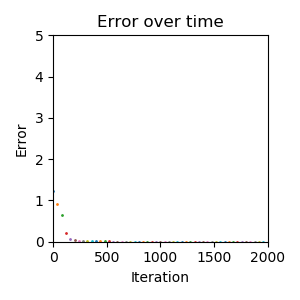

<IPython.core.display.Javascript object>


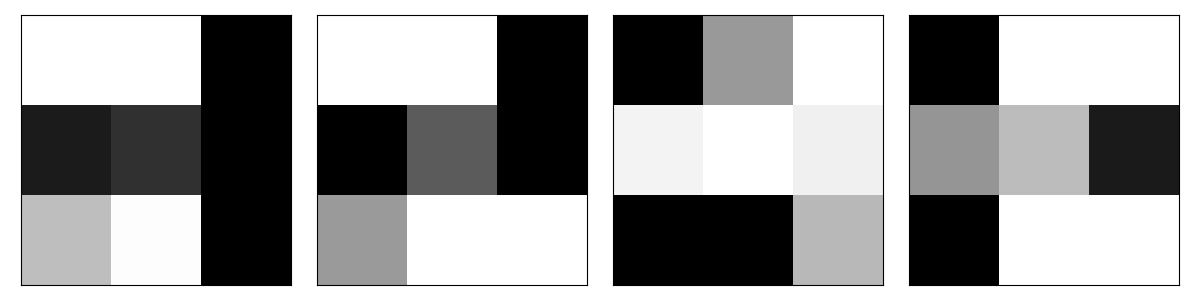

Final Error: 0.00


In [168]:
optimizeMultiPattern(numHiddenUnits=4, momentum=True) ## YOUR CODE HERE - Try different numbers of hidden units

*** YOUR TEXT HERE -- Comment on the number of hidden units needed and the differences between your hypothesis and results ***
A minimum of two hidden units are needed to solve this separation problem. The learned features vary from trial to trial, but they reflect what we had hypothesized.